## Simplified Game Engine
- No free spaces at the edge.
- Only going to 1 sequence.

Game description: https://en.wikipedia.org/wiki/Sequence_(game)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import torch
from scipy.special import softmax
from tqdm import tqdm
from game import *
from models import *

## Models

### CNN Model

In [3]:
model = cnn_scorer()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_par = sum([l.numel() for l in model.parameters() if l.requires_grad])
print(f"There are {num_par} parameters in the model.")
print(model)

There are 3987 parameters in the model.
seq_scorer(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=16, out_features=25, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.15, inplace=False)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)


In [17]:
checkpoint = torch.load('models/cur.pth')
model.load_state_dict(checkpoint) 

<All keys matched successfully>

### Linear Model

In [3]:
model = dnn_scorer()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_par = sum([l.numel() for l in model.parameters() if l.requires_grad])
print(f"There are {num_par} parameters in the model.")
print(model)

There are 14 parameters in the model.
h_scorer(
  (d1): Linear(in_features=14, out_features=1, bias=False)
)


In [4]:
checkpoint = torch.load('models/Linear/lin_4999.pth')
model.load_state_dict(checkpoint) 

<All keys matched successfully>

## Train Model With Q-Learning Algorithm

Play full game with rewards.

  4%|███▏                                                                           | 99/2500 [24:27<8:11:06, 12.27s/it]

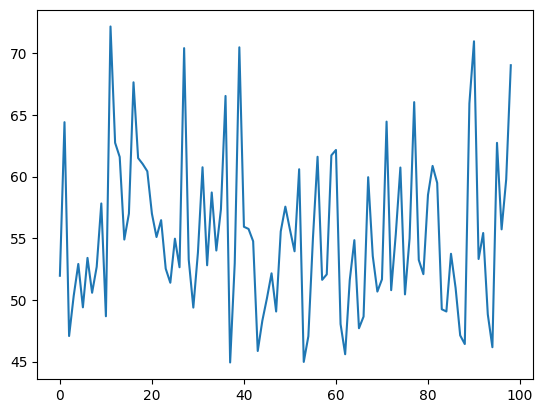

  8%|██████▏                                                                       | 199/2500 [47:51<9:21:48, 14.65s/it]

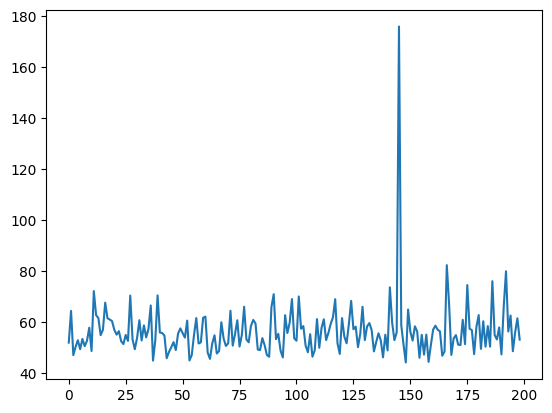

 11%|████████▌                                                                   | 281/2500 [1:08:38<7:49:12, 12.69s/it]

In [ ]:
# Temporal Difference
import copy
from tqdm import tqdm
num_games = 2500
gamma = 0.98

loss_hist = list()

stable_model = copy.deepcopy(model)
stable_model.eval()
model.train()
for g in tqdm(range(num_games)):
    game = Sequence()
    game_completed = False
    batch = list()
    lab = list()
    if g % 100 == 99:
        plt.plot(loss_hist)
        plt.show()
        torch.save(model.state_dict(), f'models/CNN/cnn_{g}.pth')
        stable_model = copy.deepcopy(model)
        stable_model.eval()
    while not game_completed:
        move, moves = game.sample_action(stable_model,T=10/(g+1)**0.5)
        if len(moves) == 0:
            break
        s_p = game.prepare_input(moves,move)
        game.play(moves[move],change_turn=False)
        R = game.check_winner()*10*game.turn
        if R != 0 or (game.deck_pos) < 0:
            game_completed = True
            target = R
        else:
            target = R
        batch.append(s_p)
        lab.append(torch.tensor([target],dtype=torch.float32))
        game.turn *= -1
        if R != 0:
            moves = game.get_moves()
            batch.append(game.prepare_input(moves,0))
            lab.append(torch.tensor([R*-1],dtype=torch.float32))
    optimizer.zero_grad()
    x = torch.stack(batch)
    r = torch.stack(lab)
    tot_bat = list()
    tot_lab = list()
    blue = torch.arange(0,len(x),2)
    red = torch.arange(1,len(x),2)
    b_dif = r[blue.max()]*((gamma)**(len(blue)-blue/2-1))
    r_dif = r[red.max()]*((gamma)**(len(red)-red/2-.5))
    Y = torch.cat((b_dif.unsqueeze(1),r_dif.unsqueeze(1)))
    X = torch.cat((x[blue],x[red]))
    V = model(X)
    loss = loss_fn(V, Y)
    loss_hist.append(loss.item())
    loss.backward()
    # Adjust learning weights
    optimizer.step()

In [15]:
torch.save(model.state_dict(), f'models/cur.pth')

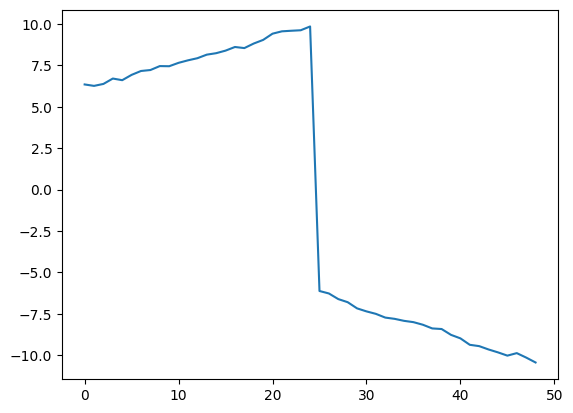

In [7]:
plt.plot(model(X).detach()-Y)

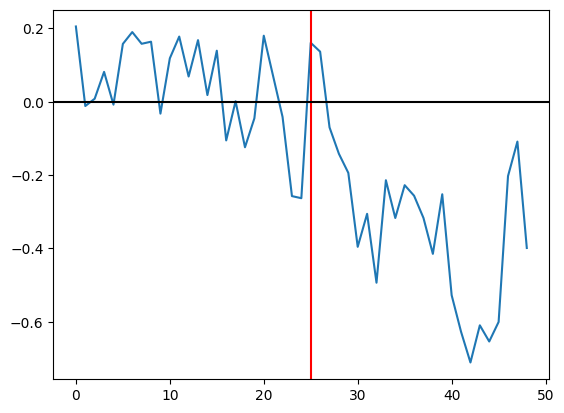

In [17]:
import math
r = model(X).detach().numpy()

plt.plot(r)
plt.axvline(math.ceil(len(r)/2),color='red')
plt.axhline(0,color='black')
plt.show()

In [181]:
pars = [p for p in model.parameters()]
pars

[Parameter containing:
 tensor([[ 0.0330,  0.0846,  0.1717,  0.4427, -0.0392, -0.0716, -0.2571, -0.4096,
           0.0378,  0.0860]], requires_grad=True)]

In [74]:
pars = [p for p in model.parameters()]
pars

[Parameter containing:
 tensor([[ 0.0782,  0.1319,  0.2657,  0.5170, -0.0873, -0.1315, -0.2892, -0.5896,
          -0.0325, -0.0223,  0.0470,  0.0769, -0.0579,  0.1044]],
        requires_grad=True)]

In [7]:
pars = [p for p in model.parameters()]
pars

[Parameter containing:
 tensor([[-0.0277,  0.2142,  0.9020,  4.3469, -0.0310, -0.2472, -1.0259, -4.2589,
           0.0483,  0.0789,  0.2042,  0.5767,  0.1258,  0.5694]],
        requires_grad=True)]

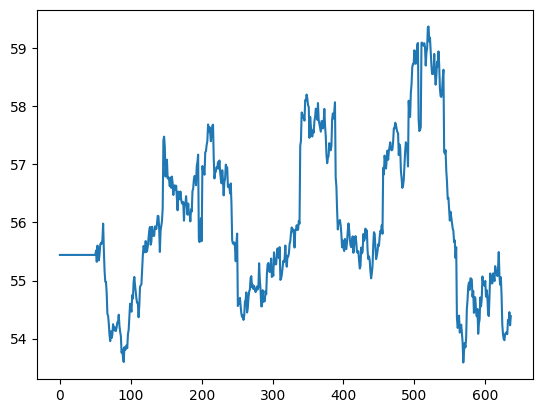

In [24]:
def moving_avg(n=5):
    avg = np.zeros(len(loss_hist))
    for i in range(n):
        avg[i] = np.exp(np.mean(np.log(loss_hist[0:n])))
    for i in range(n,len(loss_hist)):
        avg[i] = np.exp(np.mean(np.log(loss_hist[max(0,i-n):i])))
    return avg
plt.plot(moving_avg(n=50))
plt.show()